In [4]:
import pandas as pd

In [8]:
data = pd.read_csv('../letter_korean_corpus.csv')
letter = data

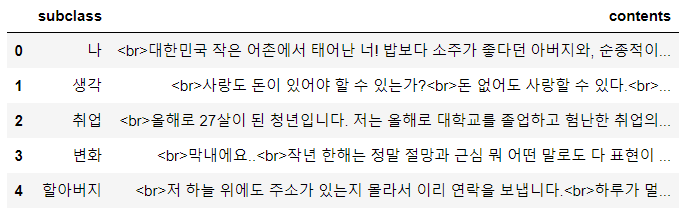

# 명사 데이터 전처리

In [ ]:
"""
    동사, 형용사에는 감정을 느낄 수 있는 단어가 많고,
    명사에는 키워드를 뽑기 쉽운 단어가 많기 때문에
    (동사/형용사), 명사로 키워드 추출 두번 진행함
"""

In [22]:
stopwords = [
    "stop", "words"
]

In [10]:
from konlpy.tag import Okt
tagger = Okt()

# 편지 내용 가져오기
contents = letter['contents']

def preprocessing(text):
    # <br>제거
    text = text.replace("<br>", " ")
    
    # 형태소 분석
    okt_pos = tagger.pos(text, norm=True, stem=True)
    
    # 명사만 사용
    words = [word for word, hts in okt_pos if hts in ['Noun']]
    
    # 스탑 워드 적용
    words = [word for word in words if word not in stopwords]
    
    #리스트 문자열로 변경
    pure_string = ' '.join(words)
    
    return pure_string

content = list(contents.apply(preprocessing))

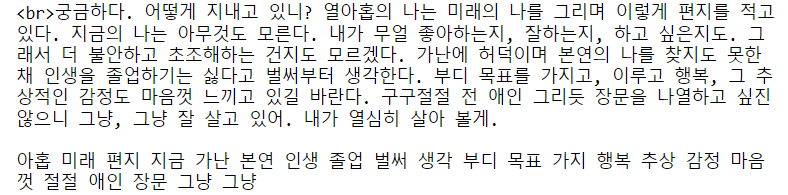

# 자주 등장하는 단어 계산, tf-idf

In [11]:
"""
    idf는 전체적으로 자주 등장하는 단어를 가중치를 낮게 준다.
    EX) '당신'이라는 단어가 전체 글뭉치에서 빈도수가 높아 가중치를 낮게,
        '사과'라는 단어는 전체 글뭉치에서 빈도수가 낮아 가중치를 높게,
        즉 가중치가 높은 순서대로 각 글의 중심 단어임을 추측할 수 있음
"""
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
words_vectors = vectorizer.fit_transform(content).toarray()

words_vectors = pd.DataFrame(words_vectors)

In [15]:
def index_to_word(search_num):
    """tf-idf의 vocab이 매칭하는 숫자를 단어로 바꿔주는 함수,
       EX) 0번 단어 -> '사랑' 
    """
    words = vectorizer.vocabulary_
    
    for word, wordnum in words.items():
        if wordnum == search_num:
            return word

In [16]:
index_rank_datafarme = []

for index in range(len(words_vectors)):
    #각 row(각 편지)의 가중치가 높은 단어 정렬, 10개만 자름
    arow = words_vectors.iloc[index]
    arow = arow.sort_values(ascending=False)[0:10]
    
    # 숫자를 단어로 변경
    str_index = []
    for key, value in arow.items():
        if value != 0.0:
            str_index.append(index_to_word(key))

    index_rank_datafarme.append(str_index)

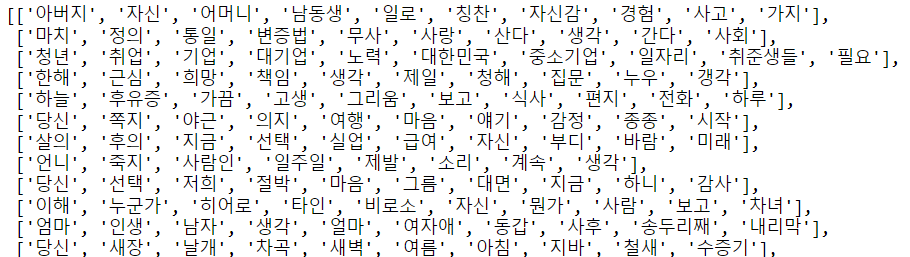

# 키워드 추출

In [23]:
from krwordrank.sentence import summarize_with_sentences

penalty = lambda x:0 if (25 <= len(x) <= 80) else 1

keywords, sents = summarize_with_sentences(
    content,                # 말뭉치
    penalty=penalty,
    stopwords = stopwords,  # stopwords
    diversity=0.7,
    num_keywords=1000,      # 추출할 키워드 개수
    num_keysents=40,
    verbose=False
)

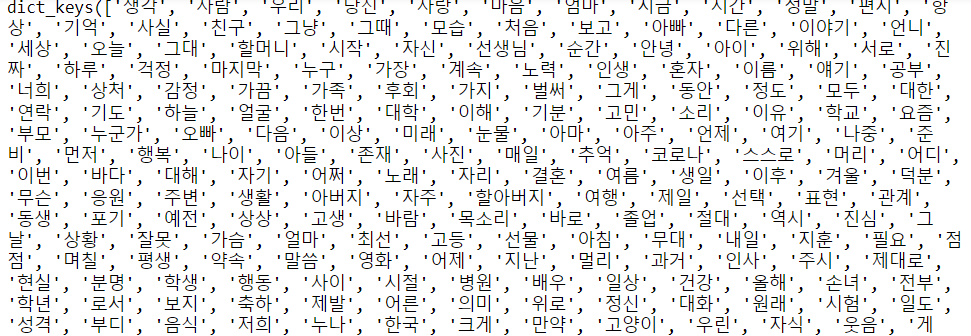  
추출한 키워드를 수기로 시에서 추출한 키워드에 따라 분류  
감정분류 : https://docs.google.com/document/d/1QQiUuiFfczXKj8UnCD8mRONARQqjc8TJcvNRwlsI0LA/edit  
키워드 분류 : https://docs.google.com/document/d/1voQ4aTac0T1G5hGzVlAR3xd1UOsUjg2UbG0EgfdpQ1c/edit  

In [27]:
final_list = []
for poem in index_rank_datafarme:
    poem_list = []
    for word in poem:
        # 각 시에서 빈도수 높은 단어 10개가 클래스로 분류한 단어들과 일치하는지 확인
        # 일치하면 그대로 리스트에 저장
        try:
            keywords[word]
            poem_list.append(word)
        # 일치하지 않으면 버림
        except KeyError:
            pass
    
    final_list.append(poem_list)

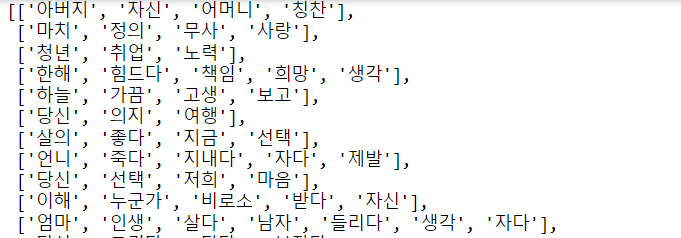

In [29]:
final_list = pd.DataFrame(final_list)
final_list.to_csv('./letter_before_labeling_nouns.csv', index=False)

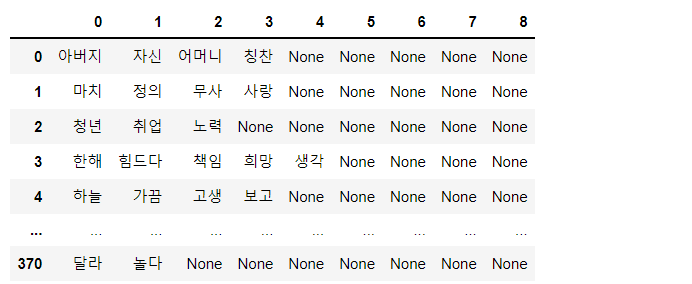

In [ ]:
"""전처리 부분 동사, 형용사로 바꿔서 동일하게 진행"""

# final_list = pd.DataFrame(final_list)
# final_list.to_csv('./letter_before_labeling_verbs.csv', index=False)